# Semi-Supervised Learning (Implementation)

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Generate Data 

Motivated by [scikit-learn](https://scikit-learn.org/stable/index.html) [moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) data set:

In [2]:
def generate_moon_sample_data(r, n, sigma, shift):

    angles = np.random.uniform(low=0, high=np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + shift[0] + x_epsilon
    y = r*np.sin(angles) + shift[1] + y_epsilon
    
    return x, y


def generate_sample_data(r, n, sigma):

    x1, y1 = generate_moon_sample_data(r, n, sigma, (0.5, - sigma/4))
    x2, y2 = generate_moon_sample_data(r, n, sigma, (-0.5, - sigma/4))
    y2 = - y2
    
    return [(x1, y1), (x2, y2)]

In [3]:
# Set radius.
r = 1.0
# Number of samples per class. 
n_c_samples = 300
# Standard deviation of normal errors.
sigma = 0.2

# Generate data set.
[(x1, y1), (x2, y2)] = generate_sample_data(r, n_c_samples, sigma)

Let us plot the data:

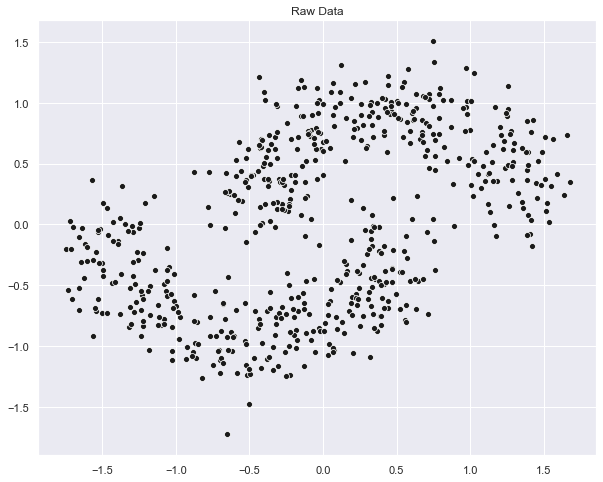

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x=x1, y=y1, color='k', ax=ax)
sns.scatterplot(x=x2, y=y2, color='k', ax=ax)

ax.set(title='Raw Data');

## Add Labeled Data 

In [5]:
# Number of samples per class.
n_c_examples = 5

[(z1, w1), (z2, w2)] = generate_sample_data(r, n_c_examples, sigma)

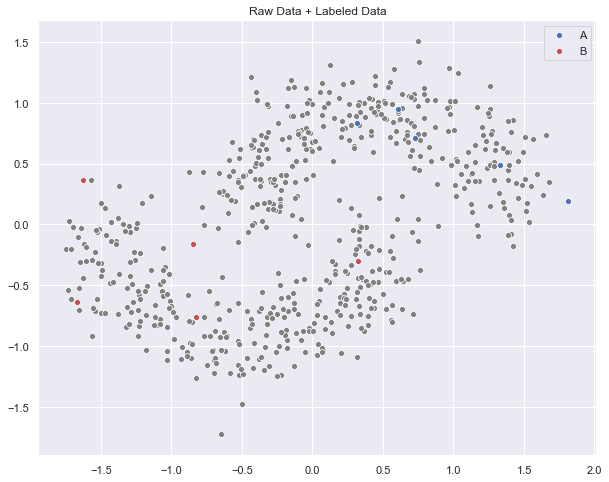

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x=x1, y=y1, color='grey', ax=ax)
sns.scatterplot(x=x2, y=y2, color='grey', ax=ax)
sns.scatterplot(x=z1, y=w1, color='b', ax=ax, label='A')
sns.scatterplot(x=z2, y=w2, color='r', ax=ax, label='B')

ax.set(title='Raw Data + Labeled Data')
ax.legend();

## Combine Data

In [7]:
true_label = [1]*len(x1) + [2]*len(x2) + [1]*len(z1) + [2]*len(z2)  
# Sample labels without tags should be indicated by -1.
sample_label =[-1]*(len(x1) + len(x2)) + [1]*len(z1) + [2]*len(z2)  

data_dict = {
    'x' : np.concatenate([x1, x2, z1, z2]),
    'y' : np.concatenate([y1, y2, w1, w2]), 
    'true_label' : true_label,
    'sample_label' : sample_label,
}

data_df = pd.DataFrame(data_dict)

Let us plot the "true" labels and the raw data + sample labels:

**Warning:** We actually do not have "true" labels, is just for illustration purposes. 

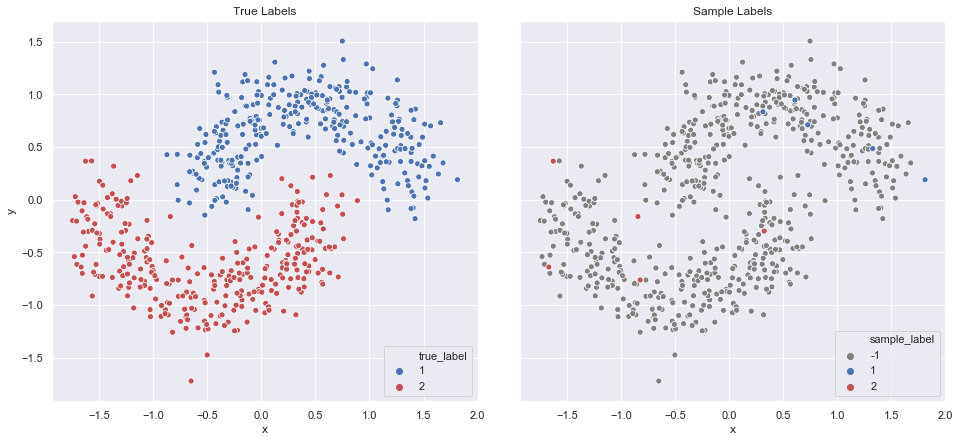

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols= 2, figsize=(16, 7), sharey=True)
fig.subplots_adjust(wspace=0.1)

sns.scatterplot(x='x', y='y', data=data_df, hue='true_label', palette=['b', 'r'], ax=ax1)
sns.scatterplot(x='x', y='y', data=data_df, hue='sample_label', palette=['grey', 'b', 'r'], ax=ax2)

ax1.set(title='True Labels')
ax1.legend(loc='lower right')
ax2.set(title='Sample Labels')
ax2.legend(loc='lower right');

## Train (scikit-learn) Semi-Supervised Model

[Here](https://scikit-learn.org/stable/modules/label_propagation.html) you can find scikit-learn's documentation on semi-supervised methods.

In [9]:
# Observation data frame.
X = data_df[['x', 'y']]
# Target variable. 
y = data_df['sample_label']

### Label Propagation 

In [10]:
from sklearn.semi_supervised import LabelPropagation

# Define model object. 
label_prop_model = LabelPropagation(kernel='rbf', gamma=10.0)
# Train model.
label_prop_model.fit(X, y)

LabelPropagation(gamma=10.0, kernel='rbf', max_iter=1000, n_jobs=None,
                 n_neighbors=7, tol=0.001)

In [11]:
# Generate predictions. 
data_df['pred_label'] = label_prop_model.predict(X)

Let us plot the predictions:

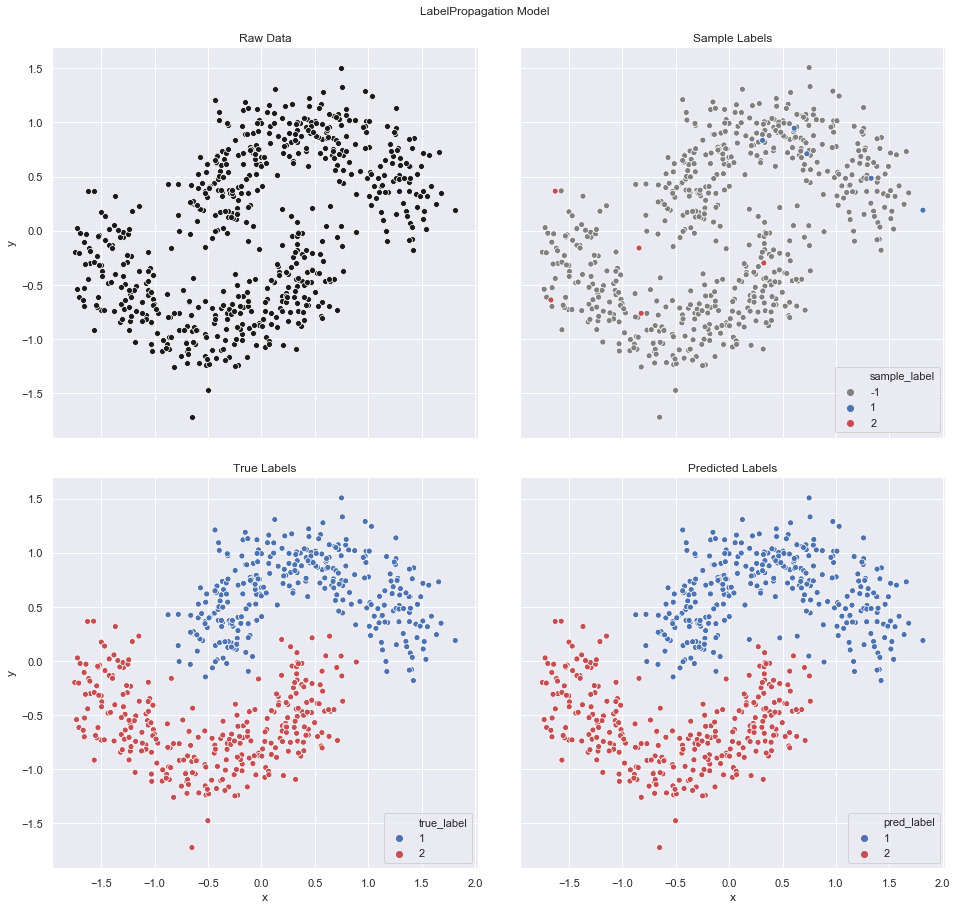

In [12]:
fig, axes = plt.subplots(nrows= 2, ncols= 2, figsize=(16, 14), sharex=True, sharey=True)
fig.subplots_adjust(top=0.94, wspace=0.1, hspace=0.1)

axes = axes.flatten()

sns.scatterplot(x='x', y='y', data=data_df, color = 'k', ax=axes[0])
sns.scatterplot(x='x', y='y', data=data_df, hue='sample_label', palette=['grey', 'b', 'r'], ax=axes[1])
sns.scatterplot(x='x', y='y', data=data_df, hue='true_label', palette=['b', 'r'], ax=axes[2])
sns.scatterplot(x='x', y='y', data=data_df, hue='pred_label', palette=['b', 'r'], ax=axes[3])

ax=axes[0].set(title='Raw Data');
ax=axes[1].set(title='Sample Labels');
ax=axes[2].set(title='True Labels');
ax=axes[3].set(title='Predicted Labels');

axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')
plt.suptitle('LabelPropagation Model');

Now, let us plot the class probability:

In [13]:
# Compute class 1 probability:
data_df['pred_proba'] = label_prop_model.predict_proba(X)[:, 0]

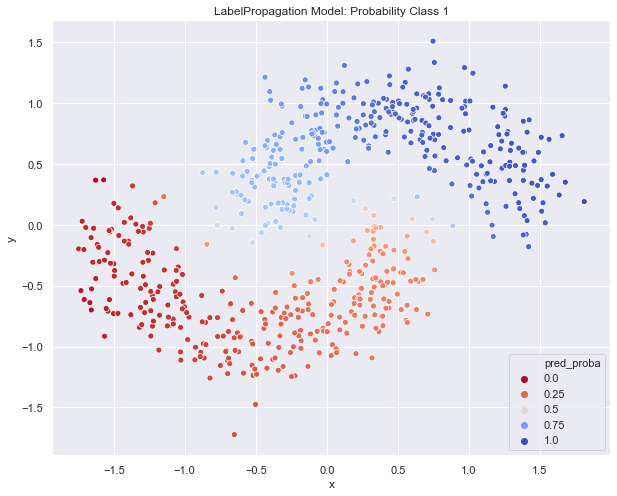

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x='x', y='y', data=data_df, hue='pred_proba', palette='coolwarm_r', ax=ax)

ax.set(title='LabelPropagation Model: Probability Class 1')
ax.legend(loc='lower right');

### LabelSpreading

In this algorithm we can use a parameter `alpha` which "*specifies the relative amount that an instance should adopt the information from its neighbors as opposed to its initial label.*" That is, measures how strict the initial labels should be. 

In [15]:
from sklearn.semi_supervised import LabelSpreading

# Define model object. 
label_spread_model = LabelSpreading(kernel='rbf', gamma=10.0, alpha=0.3)
# Train model.
label_spread_model.fit(X, y)

LabelSpreading(alpha=0.3, gamma=10.0, kernel='rbf', max_iter=30, n_jobs=None,
               n_neighbors=7, tol=0.001)

In [16]:
# Generate predictions. 
data_df['pred_label'] = label_spread_model.predict(X)

Let us plot the predictions:

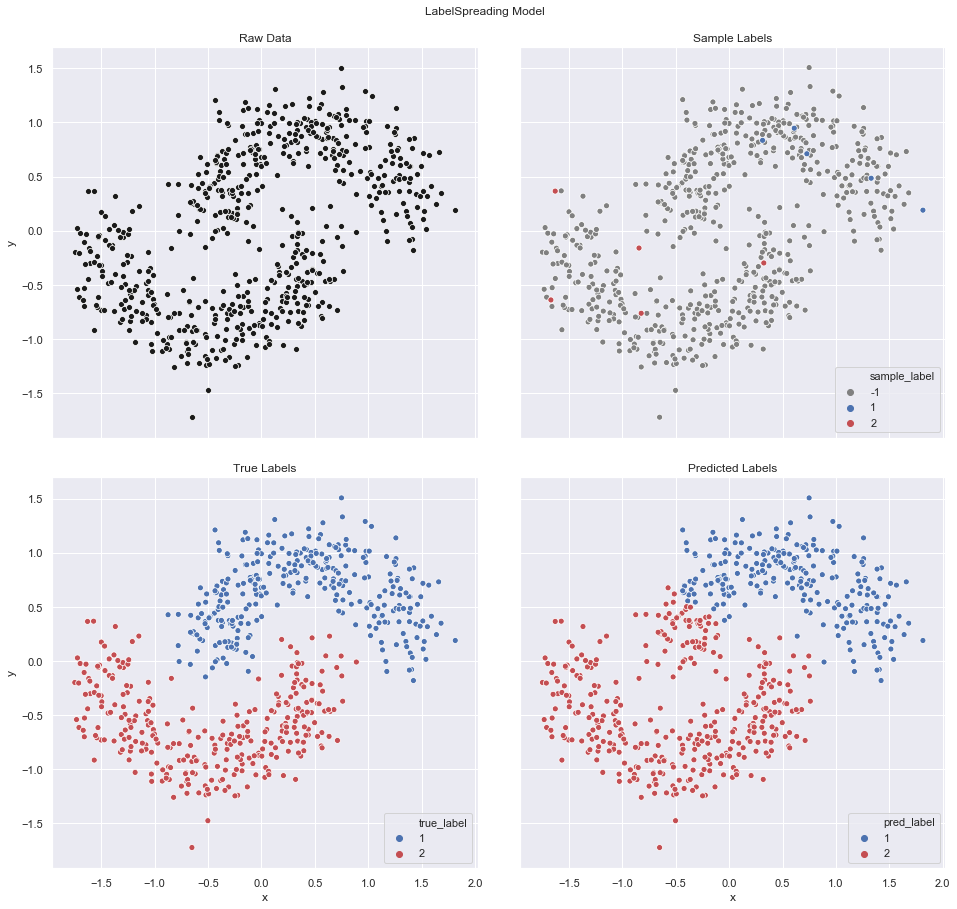

In [17]:
fig, axes = plt.subplots(nrows= 2, ncols= 2, figsize=(16, 14), sharex=True, sharey=True)
fig.subplots_adjust(top=0.94, wspace=0.1, hspace=0.1)

axes = axes.flatten()

sns.scatterplot(x='x', y='y', data=data_df, color = 'k', ax=axes[0])
sns.scatterplot(x='x', y='y', data=data_df, hue='sample_label', palette=['grey', 'b', 'r'], ax=axes[1])
sns.scatterplot(x='x', y='y', data=data_df, hue='true_label', palette=['b', 'r'], ax=axes[2])
sns.scatterplot(x='x', y='y', data=data_df, hue='pred_label', palette=['b', 'r'], ax=axes[3])

ax=axes[0].set(title='Raw Data');
ax=axes[1].set(title='Sample Labels');
ax=axes[2].set(title='True Labels');
ax=axes[3].set(title='Predicted Labels');

axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')
plt.suptitle('LabelSpreading Model');

Now, let us plot the class probability:

In [18]:
# Compute class 1 probability:
data_df['pred_proba'] = label_spread_model.predict_proba(X)[:, 0]

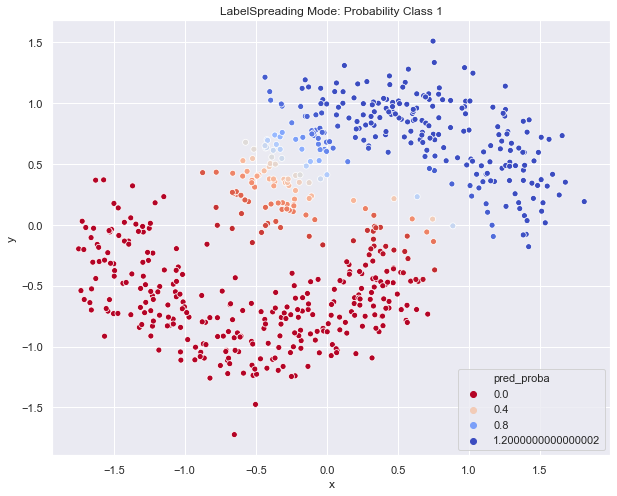

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x='x', y='y', data=data_df, hue='pred_proba', palette='coolwarm_r', ax=ax)

ax.set(title='LabelSpreading Mode: Probability Class 1')
ax.legend(loc='lower right');